# Домашнее задание 3

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 февраля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_3

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Вновь рассмотрим задачу минимизации эмпирического риска:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i).
\end{equation}

В прошлом задании работа шла с линейной модель $g(w, x) = w^T x$ и квадратичную функцию потерь $l(z, y) = (z-y)^2$. 

### __(а)__ В дополнение к квадратичной функции потерь реализуйте логистическую/сигмоидную: $l(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Выпишите градиент. Является ли новая задача регресии выпуклой? Оцените $L$ для новой функции потерь. 

### $$\sigma(x)=\frac{1}{1+e^{-x}}$$

### $$\nabla_{\omega} \ln(1+e^{-yw^Tx})=\frac{-yx}{1+e^{-yw^Tx}}e^{-yw^Tx}=-xy\sigma (-y_iw^Tx_i)$$

#### $$\nabla Loss = \nabla_w \sum\limits_{i=1}^n \ln(1+e^{-y_iw^Tx_i})=-\sum\limits_{i=1}^n\sigma(-y_iw^Tx_i)x_iy_i$$

Найдем вторые частные производные для того чтобы составить Гессиан :

#### $$\frac{\partial}{\partial w_j}\frac{\partial Loss}{\partial w^k}=-\sum\limits_{i=1}^nx_i^ky_i \frac{\partial}{\partial w_j} \frac{1}{1+e^{y_iw^Tx_i}}$$

$$|\sum\limits_{i=1}^nx_i^ky_i\frac{y_ix_i^je^{y_iw^Tx_i}}{(1+e^{y_iw^Tx_i})^2}|\leq \sum\limits_{i=1}^n|x_i^kx_i^j|$$

Тогда константу L можно оценить как норму Гессиана оценочной матрицы : $L\leq ||(\frac{\partial}{\partial w_j}\frac{\partial L}{\partial w^k})_{jk}||\leq|| ( \sum\limits_{i=1}^n|x_i^kx_i^j|)_{jk}||$

Более точная оценка дает еще коэффициент 1/4 : $$L \leq \frac{1}{4n}\sum\limits_{i=1}^nx_ix_i^T$$

Чтобы оценить выпуклость выпишем в явном виде гессиан :

$$\nabla^2 Loss=\frac{1}{n}\sum\limits_{i=1}^nx_ix_i^T \frac{e^{y_iw^tx_i}}{(1+e^{y_iw^tx_i})^2}$$

Матрица $x_ix_i^T$ является положительно полуопределенной, множитель положительный, сумма таких матриц так же будет положительно полуопределенной, значит задача выпуклая

Или выпуклость можно было получить еще просто вглядыванием :

Выпуклость функций вида логарифм от суммы экспонент доказана в дз прошлого семестра. 
Композиция этой выпуклой функции с линейной будет выпуклой. 
После этого суммируем выпуклые функции и получаем выпуклую. 
__Итого минимизируемая функция выпуклая__

### __(б)__ Возьмите датасет _mushrooms_ из прошлого задания. Проделайте следующие шаги из прошлого задания, только с логистической функцией потерь:

1) Разделите данные на две части: обучающую и тестовую.

2) Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$ задачи обучения/оптимизации.

3) Используя градиентный спуск, обучите новую модель (без ограничений и регуляризаций). Постройте график: точность от номера итерации.

4) Если в пункте 3) пришлось столкнуться с проблемами или просто необходимо улучшить точность, то добавьте ограничения или $\ell_2$-регуляризацию, как в прошлом ДЗ.

5) Сравните с результатами квадратичной функции потерь из прошлого ДЗ.

### 1.Вынимание данных

In [1]:
import numpy as np

In [2]:
dataset = "mushrooms.txt" 
#файл должен лежать в той же деректории, что и notebook#ответ

In [3]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape

Переведем признаки с меток (1,2) на метки (1,-1)

In [4]:
y=y-1.5
y=2*y

In [5]:
y

array([-1.,  1.,  1., ...,  1., -1.,  1.])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.2,test_size=0.8, random_state=41)

### 2.Оценка константы

In [7]:
Hes=np.zeros((len(X_train[0]),len(X_train[0])))
Hes.shape

(112, 112)

In [8]:
n=len(X_train)
n

1624

Тогда константу L можно оценить как норму Гессиана : $L\leq ||(\frac{\partial}{\partial w_j}\frac{\partial L}{\partial w^k})_{jk}||\leq||\frac{1}{n} ( \sum\limits_{i=1}^n|x_i^kx_i^j|)_{jk}||$

In [9]:
#Возвращает j,k -е оценки элементов гессиана
def get_hes(j,k,X):
    terms=np.zeros(np.shape(X)[0])
    for i in range(len(terms)):
        terms[i]= abs(X[i][k]*X[i][j])
    return terms.sum()

In [10]:
def get_L(X):
    summ=0
    for row in X:
        summ+=np.dot(row.T,row)
    return summ/(4*n)

In [11]:
L=get_L(X_train)
print(L)

5.25


### 3.Обучение и результаты

#### $$\nabla L = \nabla_w \sum\limits_{i=1}^n \ln(1+e^{-y_iw^Tx_i})=-\sum\limits_{i=1}^n\sigma(-y_iw^Tx_i)x_iy_i$$

In [12]:
def sigma(x):
    return 1/(1+np.exp(-x))

In [13]:
terms=np.zeros((np.shape(X_train)[0],len(X[0])))
terms[0].shape

(112,)

In [14]:
def gradient(X,y,w):
    summ=0
    for i in range(np.shape(X)[0]):
        summ+=sigma(-y[i]*np.matmul(w.T,X[i]))*X[i]*y[i]
    return -summ/n

In [15]:
def gradient_decline_iteration(x_k,gamma_k,X,y):
    x_new=x_k-gamma_k*gradient(X,y,x_k);
    return x_new;

def gradient_decline(X,y,x,gamma,iterations,epsilon):
    x_prev=x
    arr=[]
    for i in range(iterations):
        x_prev=x
        x=gradient_decline_iteration(x,gamma,X,y)
        arr.append(np.linalg.norm(x-x_prev))
        if(np.linalg.norm(x-x_prev) < epsilon):
            break
    return x,arr

In [16]:
ITERATIONS=200      #Максимальное число итераций
EPSILON=0.0001        #Точность 
START=np.zeros(len(X[0])) #Стартовая точка

In [17]:
x,arr=gradient_decline(X_train,y_train,START,1/L,ITERATIONS,EPSILON)

In [18]:
import matplotlib.pyplot as plt
#arr = [1, 2, 3, 4, 5]
#почему-то чтобы график прогрузился нужно запустить ячейку еще раз
plt.plot(range(len(arr)), arr)
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.show()

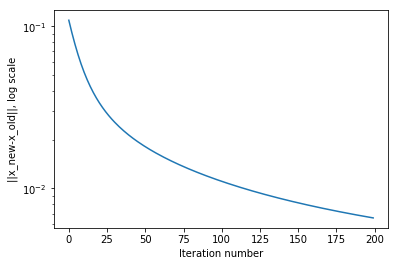

In [19]:
import matplotlib.pyplot as plt
#arr = [1, 2, 3, 4, 5]
#почему-то чтобы график прогрузился нужно запустить ячейку еще раз
plt.plot(range(len(arr)), arr)
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.show()

#### $$Loss=\sum\limits_{i=1}^n \ln(1+e^{-y_iw^Tx_i})$$

In [20]:
percentage=[]
max_iterations=600
step=100
for i in range(step,max_iterations,step):
    ITERATIONS=i
    x,arr=gradient_decline(X_train,y_train,START,1/L,ITERATIONS,EPSILON)
    
    y_pred=[]
    for i in range(len(X_test)):
        y_pred.append(np.matmul(x,X_test[i]))
        
    Delta=0
    for i in range(len(y_pred)):
        if(y_pred!=0):
            if(y_pred[i]/abs(y_pred[i])==y_test[i]):
                Delta+=1
    percentage.append(Delta/len(y_test))

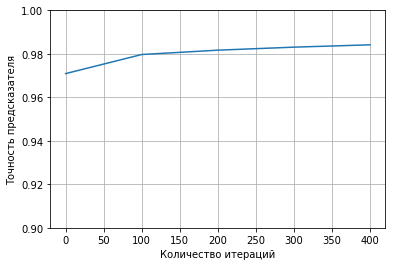

In [21]:
import matplotlib.pyplot as plt

#arr = [1, 2, 3, 4, 5]
xaxis=np.arange(0,len(percentage),1) 
xaxis*=step

plt.plot(xaxis, percentage)

plt.xlabel("Количество итераций")
plt.ylabel("Точность предсказателя")
plt.ylim((0.9,1))
plt.grid()
plt.show()

Все !

## Задача 2

### __(a)__ Реализуйте метод тяжелого шарика. 

In [22]:
def gradient_decline_iteration_ball(x_k,x_before,gamma_k,X,y,momentum):
    x_new=x_k-gamma_k*gradient(X,y,x_k)-momentum*(x_k-x_before);
    return x_new;

def gradient_decline_ball(X,y,x,gamma,iterations,epsilon,momentum):
    x_prev=x
    x_prev_prev=x
    arr=[]
    for i in range(iterations):
        x=gradient_decline_iteration_ball(x_prev,x_prev_prev,gamma,X,y,momentum)
        arr.append(np.linalg.norm(x-x_prev))
        if(np.linalg.norm(x-x_prev) < epsilon):
            break
        x_prev_prev=x_prev
        x_prev=x
    return x,arr

### __(б)__ Решите задачу логистической регрессии с помощью метода тяжелого шарика (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

In [23]:
ITERATIONS=100    #Максимальное число итераций
EPSILON=0.0001        #Точность 
START=np.zeros(len(X[0])) #Стартовая точка

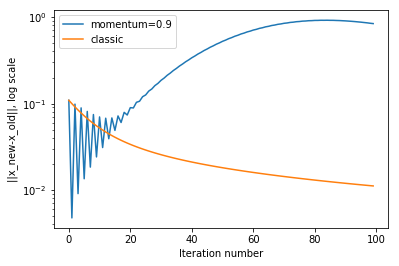

In [24]:
MOMENTUM=0.90
x2,arr2=gradient_decline(X_train,y_train,START,1/L,ITERATIONS,EPSILON)
x,arr=gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)

import matplotlib.pyplot as plt


plt.plot(range(len(arr)), arr,label='momentum={}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

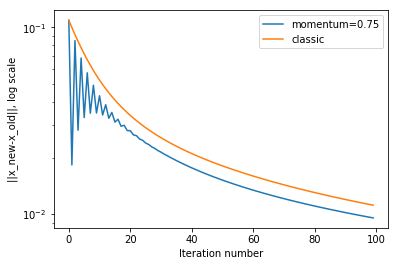

In [25]:
MOMENTUM=0.75
x,arr=gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)

plt.plot(range(len(arr)), arr,label='momentum={}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

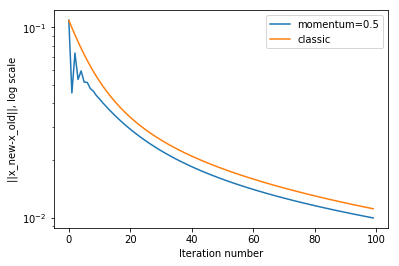

In [26]:
MOMENTUM=0.5
x,arr=gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)

plt.plot(range(len(arr)), arr,label='momentum={}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

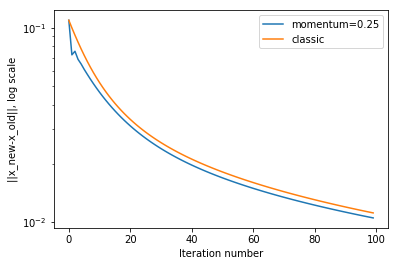

In [27]:
MOMENTUM=0.25
x,arr=gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)

plt.plot(range(len(arr)), arr,label='momentum={}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

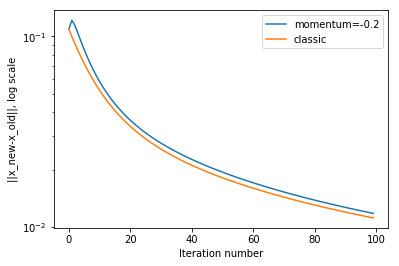

In [28]:
MOMENTUM=-0.2
x,arr=gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)

plt.plot(range(len(arr)), arr,label='momentum={}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

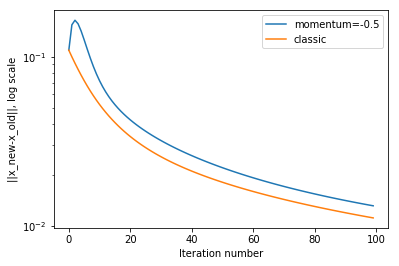

In [29]:
MOMENTUM=-0.5
x,arr=gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)

plt.plot(range(len(arr)), arr,label='momentum={}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

__Сходимость не всегда является монотонной - в некоторые моменты наш шарик начинает колебаться - оно и понтяно, ведь наш шарик получает инерцию, а значит что при попадании в "желоб" он будет продолжать некоторое время двигаться по стенкам желоба - это и отображается зигзагом на графике__

Выберем наилучший моментум : 

In [30]:
momentums=np.array(range(3,42,3))
momentums=momentums-20
momentums=momentums/20
momentums

array([-0.85, -0.7 , -0.55, -0.4 , -0.25, -0.1 ,  0.05,  0.2 ,  0.35,
        0.5 ,  0.65,  0.8 ,  0.95])

In [31]:
ITERATIONS=100            #Максимальное число итераций
EPSILON=0.0001            #Точность 
START=np.zeros(len(X[0])) #Стартовая точка

In [32]:
a=[]
for MOMENTUM in momentums:
    a.append(gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM))

In [33]:
results=[]
minn=0
for i in range(len(a)):
    results.append(a[i][1][-1])
    if (a[minn][1][-1] > a[i][1][-1]):
        minn=i
print("Оптимальный моментум для метода шарика {} ".format(momentums[minn]))

Оптимальный моментум для метода шарика 0.8 


Теперь пойдем обучать :

In [34]:
ITERATIONS=100            #Максимальное число итераций
EPSILON=0.0001            #Точность 
MOMENTUM=momentums[minn]  #Моментум шарика
START=np.zeros(len(X[0])) #Стартовая точка

In [35]:
percentage=[]
max_iterations=600
step=100
for i in range(step,max_iterations,step):
    ITERATIONS=i
    x,arr=gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)
    
    y_pred=[]
    for i in range(len(X_test)):
        y_pred.append(np.matmul(x,X_test[i]))
        
    Delta=0
    for i in range(len(y_pred)):
        if(y_pred!=0):
            if(y_pred[i]/abs(y_pred[i])==y_test[i]):
                Delta+=1
    percentage.append(Delta/len(y_test))

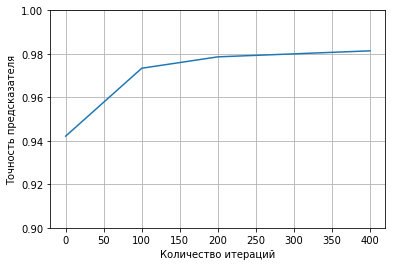

In [36]:
import matplotlib.pyplot as plt

#arr = [1, 2, 3, 4, 5]
xaxis=np.arange(0,len(percentage),1) 
xaxis*=step

plt.plot(xaxis, percentage)

plt.xlabel("Количество итераций")
plt.ylabel("Точность предсказателя")
plt.ylim((0.9,1))
plt.grid()
plt.show()

__(в)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте на этот же график сходимость градиентного спуска с шагом $\frac{1}{L}$. Сделайте вывод.

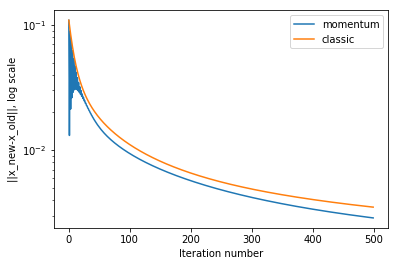

In [37]:
MOMENTUM=momentums[minn]
x2,arr2=gradient_decline(X_train,y_train,START,1/L,ITERATIONS,EPSILON)
x,arr=gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)

plt.plot(range(len(arr)), arr,label='momentum')
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

__(г)__ Если в пунктах (б) и (в) столкнулись с проблемами, попробуйте $\ell_2$-регуляризовать задачу или рассмотреть ее на ограниченном множестве.

__(д)__ Реализуйте ускоренный метод Нестерова (в форме Нестерова, а не который доказывали на семинаре). 

In [38]:
def gradient_decline_iteration_Nesterov(x_k,x_before,gamma,X,y,momentum):
    y_k=x_k-momentum*(x_k-x_before);
    x_new=y_k-gamma*gradient(X,y,y_k);
    return x_new;

def gradient_decline_Nesterov(X,y,x,gamma,iterations,epsilon,momentum):
    x_prev=x
    x_prev_prev=x
    arr=[]
    for i in range(iterations):
        x=gradient_decline_iteration_Nesterov(x_prev,x_prev_prev,gamma,X,y,momentum)
        arr.append(np.linalg.norm(x-x_prev))
        if(np.linalg.norm(x-x_prev) < epsilon):
            break
        x_prev_prev=x_prev
        x_prev=x
    return x,arr

### __(е)__ Решите задачу логистической регресии с помощью метода Нестерова (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Проверьте также значения моментума равные $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ - номер итерации), а если решаете сильно выпуклую задачу, то и $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

### 1.Фиксированный шаг, перебираем моментумы

In [39]:
ITERATIONS=100            #Максимальное число итераций
EPSILON=0.0001            #Точность 
MOMENTUM=-0.25  #Моментум шарика
START=np.zeros(len(X[0])) #Стартовая точка

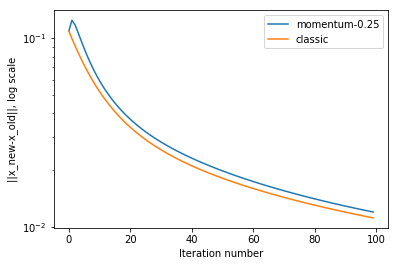

In [40]:
x,arr=gradient_decline_Nesterov(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)
x2,arr2=gradient_decline(X_train,y_train,START,1/L,ITERATIONS,EPSILON)

plt.plot(range(len(arr)), arr,label='momentum{}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

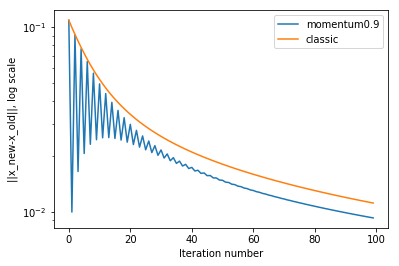

In [41]:
MOMENTUM=0.9
x,arr=gradient_decline_Nesterov(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)
plt.plot(range(len(arr)), arr,label='momentum{}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

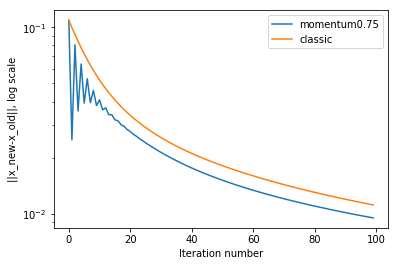

In [42]:
MOMENTUM=0.75
x,arr=gradient_decline_Nesterov(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)
plt.plot(range(len(arr)), arr,label='momentum{}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

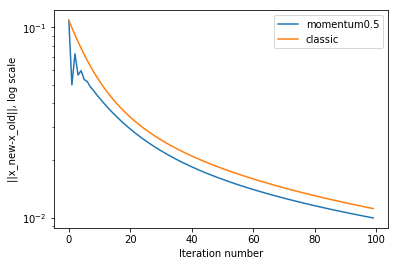

In [43]:
MOMENTUM=0.5
x,arr=gradient_decline_Nesterov(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)
plt.plot(range(len(arr)), arr,label='momentum{}'.format(MOMENTUM))
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

In [44]:
momentums_Nes=np.array(range(3,42,3))
momentums_Nes=momentums_Nes-20
momentums_Nes=momentums_Nes/20
momentums_Nes

array([-0.85, -0.7 , -0.55, -0.4 , -0.25, -0.1 ,  0.05,  0.2 ,  0.35,
        0.5 ,  0.65,  0.8 ,  0.95])

In [45]:
ITERATIONS=50            #Максимальное число итераций
EPSILON=0.0001            #Точность 
START=np.zeros(len(X[0])) #Стартовая 

In [46]:
a=[]
for MOMENTUM in momentums_Nes:
    a.append(gradient_decline_Nesterov(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM))

In [47]:
results=[]
minn_Nes=0
for i in range(len(a)):
    results.append(a[i][1][-1])
    if (a[minn_Nes][1][-1] > a[i][1][-1]):
        minn_Nes=i
print("Оптимальный моментум для метода Нестерова {}".format(momentums_Nes[minn_Nes]))

Оптимальный моментум для метода Нестерова 0.95


In [48]:
percentage=[]
max_iterations=300
MOMENTUM_Nes=momentums_Nes[minn_Nes]
step=50
for i in range(step,max_iterations,step):
    ITERATIONS=i
    x,arr=gradient_decline_Nesterov(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM_Nes)
    
    y_pred=[]
    for i in range(len(X_test)):
        y_pred.append(np.matmul(x,X_test[i]))
        
    Delta=0
    for i in range(len(y_pred)):
        if(y_pred!=0):
            if(y_pred[i]/abs(y_pred[i])==y_test[i]):
                Delta+=1
    percentage.append(Delta/len(y_test))

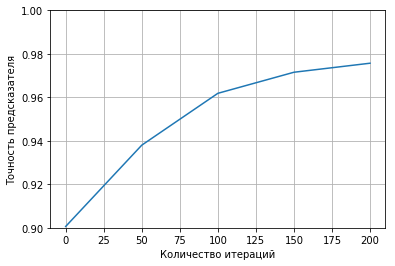

In [49]:
import matplotlib.pyplot as plt

#arr = [1, 2, 3, 4, 5]
xaxis=np.arange(0,len(percentage),1) 
xaxis*=step

plt.plot(xaxis, percentage)

plt.xlabel("Количество итераций")
plt.ylabel("Точность предсказателя")
plt.ylim((0.9,1))
plt.grid()
plt.show()

### 2.MOMENTUM=$\frac{k}{k+1}$

In [50]:
def gradient_decline_iteration_Nesterov(x_k,x_before,gamma,X,y,momentum):
    y_k=x_k-momentum*(x_k-x_before);
    x_new=y_k-gamma*gradient(X,y,y_k);
    return x_new;

def gradient_decline_Nesterov_k1(X,y,x,gamma,iterations,epsilon):
    x_prev=x
    x_prev_prev=x
    arr=[]
    for i in range(iterations):
        momentum=i/(i+1)
        x=gradient_decline_iteration_Nesterov(x_prev,x_prev_prev,gamma,X,y,momentum)
        arr.append(np.linalg.norm(x-x_prev))
        if(np.linalg.norm(x-x_prev) < epsilon):
            break
        x_prev_prev=x_prev
        x_prev=x
    return x,arr

In [51]:
ITERATIONS=200          #Максимальное число итераций
EPSILON=0.0001            #Точность 
START=np.zeros(len(X[0])) #Стартовая 

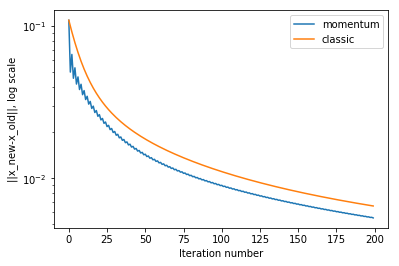

In [52]:
x,arr=gradient_decline_Nesterov_k1(X_train,y_train,START,1/L,ITERATIONS,EPSILON)
x2,arr2=gradient_decline(X_train,y_train,START,1/L,ITERATIONS,EPSILON)

plt.plot(range(len(arr)), arr,label='momentum')
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

### 3.MOMENTUM=$\frac{k}{k+3}$

In [53]:
def gradient_decline_Nesterov_k3(X,y,x,gamma,iterations,epsilon):
    x_prev=x
    x_prev_prev=x
    arr=[]
    for i in range(iterations):
        momentum=i/(i+3)
        x=gradient_decline_iteration_Nesterov(x_prev,x_prev_prev,gamma,X,y,momentum)
        arr.append(np.linalg.norm(x-x_prev))
        if(np.linalg.norm(x-x_prev) < epsilon):
            break
        x_prev_prev=x_prev
        x_prev=x
    return x,arr

In [54]:
x,arr3=gradient_decline_Nesterov_k3(X_train,y_train,START,1/L,ITERATIONS,EPSILON)

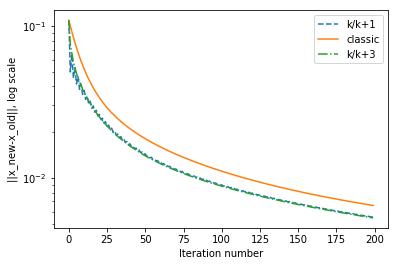

In [55]:

plt.plot(range(len(arr)), arr,label='k/k+1',linestyle='--')
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.plot(range(len(arr3)),arr3,label='k/k+3',linestyle='-.')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

__Сходимость не всегда монотонна, объяснение аналогично методу тяжелого шарика__

__(ж)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте этот график к графикам для тяжелого шарика и градиентного спуска из пункта (г). Сделайте итоговый вывод.

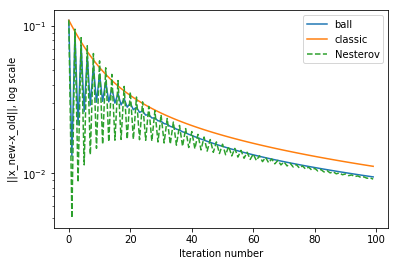

In [56]:
ITERATIONS=100
MOMENTUM=momentums[minn]
MOMENTUM_Nes=momentums_Nes[minn_Nes]
x3,arr3=gradient_decline_Nesterov(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM_Nes)
x2,arr2=gradient_decline(X_train,y_train,START,1/L,ITERATIONS,EPSILON)
x,arr=gradient_decline_ball(X_train,y_train,START,1/L,ITERATIONS,EPSILON,MOMENTUM)

plt.plot(range(len(arr)), arr,label='ball')
plt.plot(range(len(arr2)),arr2,label='classic',linestyle='-')
plt.plot(range(len(arr3)),arr3,label='Nesterov',linestyle='--')
plt.xlabel("Iteration number")
plt.ylabel("||x_new-x_old||, log scale")
plt.yscale('log')
plt.legend()
plt.show()

__Бонусные пункт__

__(з)__ Сделаем подбор константы $L$ адаптивным. Как упоминалось на семинаре, можно измерять локальную $L$, используя:
$$
f(y) \leq f(x^k) + \langle \nabla f(x^k), y - x^k \rangle + \frac{L}{2}\|x^k - y\|_2^2
$$
В частности, может подойти процедура:

```python
def backtracking_L(f, grad, x, h, L0, rho):
    L = L0
    fx = f(x)
    gradx = grad(x)
    while True:
        y = x - 1 / L * h
        if f(y) <= fx - 1 / L gradx.dot(h) + 1 / (2 * L) h.dot(h):
            break
        else:
            L = L * rho
    return L
```

Каким стоит взять __h__? __rho__ должно быть больше или меньше 1? __L0__ надо брать заведомо большим или маленьким?

In [57]:
#ответ

__(и)__ Поэксперементируйте с этой процедурой, встроенной в подбор $L$ для шага градиентного спуска. В качестве задачи продолжайте рассматривать логистическую регрессию из Задачи 1. Аналогично встройте процедуру подбора $L$ в метод тяжелого шарика и ускоренный метод Нестерова. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно). Отобразите на этом графике градиентный спуск, тяжелый шарик и метод Нестерова с адаптивным шагом и шагом $\frac{1}{L}$ (всего 6 линий на графике). Сделайте вывод.

In [58]:
#ответ

__(к)__ Постройте аналогичный пункту (и) график точности модели от времени.

In [59]:
#ответ

__(л)__ В [работе](https://arxiv.org/pdf/1204.3982.pdf) представлена техника рестартов для подавления немонотонной сходимости Алгоритма 2 (метод Нестерова). Попробуйте повторить эксперименты авторов на $\ell_2$-регуляризованной квадратичной или логистической регресии. Возьмите параметр регуляризации $\lambda = L / 100$.

In [60]:
#ответ